<a href="https://colab.research.google.com/github/Pineappledeydre/nafld_prediction/blob/main/Kim_Prediction_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
from scipy.stats import ttest_ind, stats
import csv
from scipy.special import expit

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE,SelectFromModel

In [30]:
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
combined_df = pd.read_csv('/content/drive/MyDrive/Data/KIM_2024/Данные_Почищенные/for_analysis_merged.csv')
observation_merged_df = pd.read_csv('/content/drive/MyDrive/Data/KIM_2024/Данные_Почищенные/observation_merged.csv')
comparison_merged_df = pd.read_csv (('/content/drive/MyDrive/Data/KIM_2024/Данные_Почищенные/comparison_merged.csv'))

## Прогнозирование

0.0 может обозначать отсутствие заболевания или контрольную группу.

1.0 может обозначать наличие заболевания или экспериментальную группу.

In [33]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ФИО        180 non-null    object 
 1   Пол        180 non-null    object 
 2   Возраст    180 non-null    int64  
 3   Рост,см    180 non-null    int64  
 4   Вес,кг     180 non-null    float64
 5   О.ж.,%     180 non-null    float64
 6   Висц.ж,%   180 non-null    int64  
 7   Мыш.м,%    180 non-null    float64
 8   Скелет,%   180 non-null    float64
 9   Кости,кг   180 non-null    float64
 10  Вода,%     180 non-null    float64
 11  СООВ,ккал  180 non-null    int64  
 12  ОГ,см      180 non-null    int64  
 13  ОТ,см      180 non-null    int64  
 14  ОЖ,см      180 non-null    int64  
 15  ОБ,см      180 non-null    float64
 16  ИМТ        180 non-null    float64
 17  АЛТ        180 non-null    float64
 18  АСТ        180 non-null    float64
 19  ГГТП       180 non-null    float64
 20  ЩФ        

In [34]:
# Удаление ненужных столбцов
combined_df = combined_df.drop(columns=['ФИО'])
combined_df = combined_df.drop(columns=['Рост,см'])
combined_df = combined_df.drop(columns=['Вес,кг'])  # Так как есть ИМТ

if 'Пол' in combined_df.columns:
    combined_df['Пол'] = combined_df['Пол'].replace({'жен': 1, 'муж': 0})

<ipython-input-34-fc768ffa810c>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['Пол'] = combined_df['Пол'].replace({'жен': 1, 'муж': 0})


In [38]:
combined_df.rename(columns={'Болен': 'Group'}, inplace=True)

### Correlation

In [35]:
# Вычисление матрицы корреляции
correlation_matrix = combined_df.corr().abs()

# Установление порога корреляции
correlation_threshold = 0.55

# Выбор признаков, которые превышают порог корреляции
highly_correlated_features = np.where(correlation_matrix >= correlation_threshold)
highly_correlated_features = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) for x, y in zip(*highly_correlated_features) if x != y and x < y]


In [36]:
# Print out the highly correlated feature pairs
print("Highly correlated features:")
# for feature_pair in highly_correlated_features:
#     print(feature_pair)

Highly correlated features:


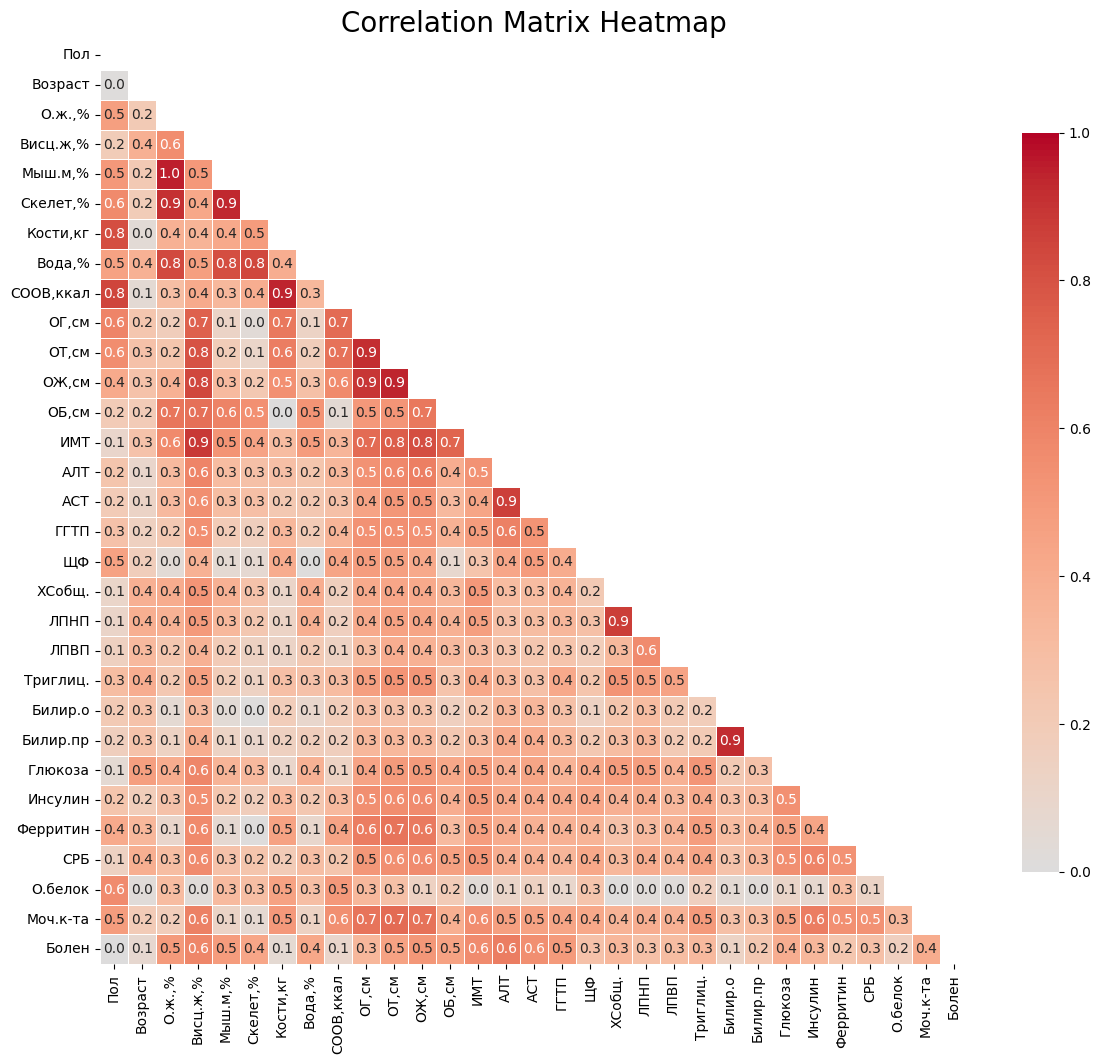

In [37]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))  # Bigger figure size

# Draw the heatmap with the mask
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.1f',
                      linewidths=0.5, vmin=0, vmax=1, mask=mask,
                      cbar_kws={"shrink": .8})  # Add colorbar with smaller shrinkage

# Adjust font size
plt.title('Correlation Matrix Heatmap', size=20)  # Bigger title
plt.xticks(size=10)  # Smaller x-axis labels
plt.yticks(size=10)  # Smaller y-axis labels

# Display the plot
plt.show()

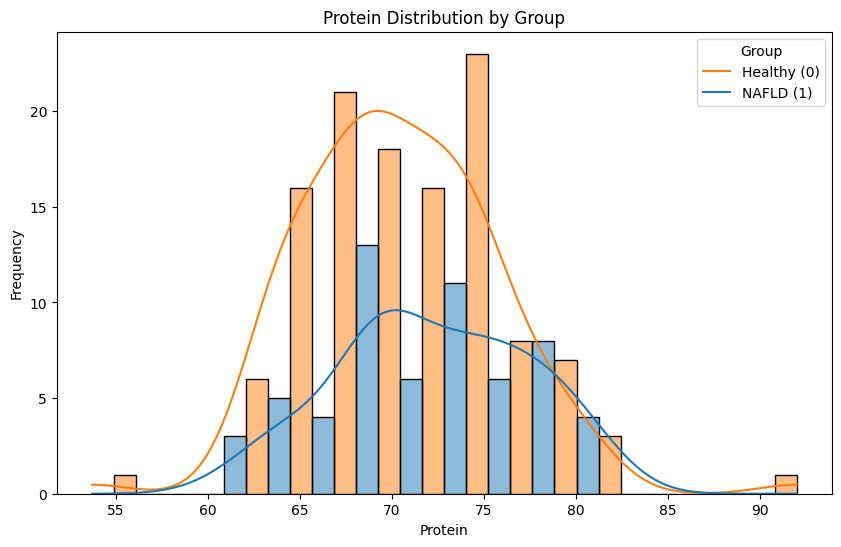

In [39]:
# Распределение возраста по группам
plt.figure(figsize=(10, 6))
sns.histplot(data= combined_df, x="О.белок",
             hue="Group", multiple="dodge", kde=True)
plt.title("Protein Distribution by Group")
plt.xlabel("Protein")
plt.ylabel("Frequency")
plt.legend(title="Group", labels=["Healthy (0)", "NAFLD (1)"])
plt.show()

In [40]:
mean_protein_group_0 = combined_df[combined_df['Group'] == 0]['О.белок'].mean()
mean_protein_group_1 = combined_df[combined_df['Group'] == 1]['О.белок'].mean()

mean_protein_group_0, mean_protein_group_1

(72.235, 70.4275)

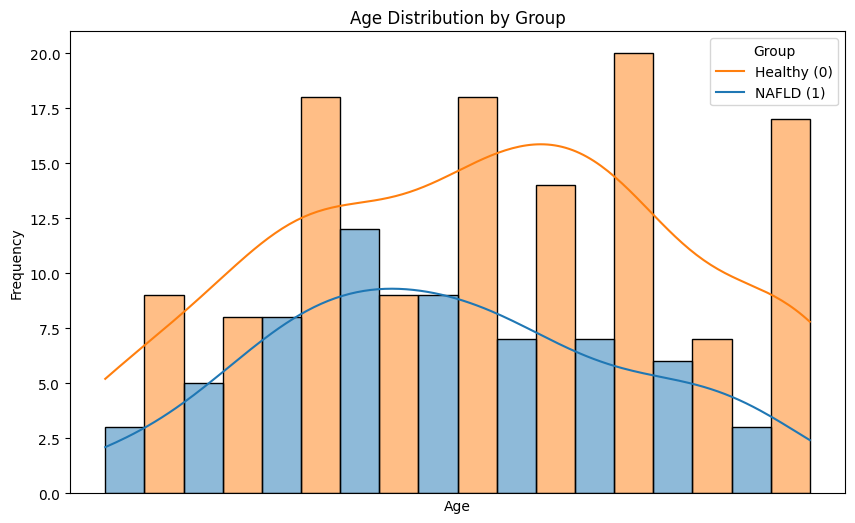

In [41]:
# Распределение возраста по группам
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=combined_df, x="Возраст", hue="Group", multiple="dodge", kde=True)
plt.title("Age Distribution by Group")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(title="Group", labels=["Healthy (0)", "NAFLD (1)"])

# Настройка меток на оси x
age_ticks = range(int(combined_df["Возраст"].min()), int(combined_df["Возраст"].max()) + 1, 5)  # Шаг меток 5 лет (настраиваем по необходимости)
ax.set_xticks([])
ax.set_xticklabels([])

plt.show()


In [42]:
mean_age_group_0 = combined_df[combined_df['Group'] == 0]['Возраст'].mean()
mean_age_group_1 = combined_df[combined_df['Group'] == 1]['Возраст'].mean()

mean_age_group_0, mean_age_group_1

(42.03333333333333, 43.625)

## Feature selection

In [43]:
# Define features and target
features = ['Пол', 'Возраст', 'О.ж.,%', 'Висц.ж,%', 'Мыш.м,%', 'Скелет,%',
            'Кости,кг', 'Вода,%', 'СООВ,ккал', 'ОГ,см', 'ОТ,см', 'ОЖ,см', 'ОБ,см',
            'ИМТ', 'АЛТ', 'АСТ', 'ГГТП', 'ЩФ', 'ХСобщ.', 'ЛПНП', 'ЛПВП', 'Триглиц.',
            'Билир.о', 'Билир.пр', 'Глюкоза', 'Инсулин', 'Ферритин', 'СРБ',
            'О.белок', 'Моч.к-та']
target = 'Group'

X = combined_df[features]
y = combined_df[target]

# Add constant for VIF calculation
X_const = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif_data = vif_data[vif_data["Feature"] != "const"]  # Remove the constant term
print(vif_data)

# Remove features with high VIF values (e.g., VIF > 5.5)
# High VIF values indicate that a feature is highly correlated with one or more other features in the dataset.

high_vif_features = vif_data[vif_data["VIF"] > 8]["Feature"].tolist()
X = X.drop(columns=high_vif_features)

# Evaluate feature importance with Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)
print('\n')
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

      Feature        VIF
1         Пол  10.567238
2     Возраст   2.198152
3      О.ж.,%  16.271429
4    Висц.ж,%   9.664759
5     Мыш.м,%  15.461446
6    Скелет,%  13.977006
7    Кости,кг  13.821221
8      Вода,%   5.010207
9   СООВ,ккал  16.099483
10      ОГ,см  10.993683
11      ОТ,см  16.624771
12      ОЖ,см  19.964443
13      ОБ,см   4.528864
14        ИМТ   7.360842
15        АЛТ   5.638109
16        АСТ   5.038837
17       ГГТП   2.036661
18         ЩФ   2.340512
19     ХСобщ.   7.420837
20       ЛПНП   7.810826
21       ЛПВП   2.383061
22   Триглиц.   2.482251
23    Билир.о   8.837016
24   Билир.пр   8.981900
25    Глюкоза   2.721822
26    Инсулин   2.506788
27   Ферритин   2.429168
28        СРБ   2.427326
29    О.белок   2.013835
30   Моч.к-та   3.017672


     Feature  Importance
4        АЛТ    0.256368
5        АСТ    0.175558
3        ИМТ    0.126855
6       ГГТП    0.083909
1     Вода,%    0.054877
17  Моч.к-та    0.048226
2      ОБ,см    0.034757
12   Глюкоза    0.03149

In [ ]:
# X = combined_df[features]
# print(X.columns)

# X = X.drop(columns=high_vif_features)
# print(X.columns)

Index(['Пол', 'Возраст', 'О.ж.,%', 'Висц.ж,%', 'Мыш.м,%', 'Скелет,%',
       'Кости,кг', 'Вода,%', 'СООВ,ккал', 'ОГ,см', 'ОТ,см', 'ОЖ,см', 'ОБ,см',
       'ИМТ', 'АЛТ', 'АСТ', 'ГГТП', 'ЩФ', 'ХСобщ.', 'ЛПНП', 'ЛПВП', 'Триглиц.',
       'Билир.о', 'Билир.пр', 'Глюкоза', 'Инсулин', 'Ферритин', 'СРБ',
       'О.белок', 'Моч.к-та'],
      dtype='object')
Index(['Возраст', 'Вода,%', 'ОБ,см', 'ИМТ', 'АЛТ', 'АСТ', 'ГГТП', 'ЩФ',
       'ХСобщ.', 'ЛПНП', 'ЛПВП', 'Триглиц.', 'Глюкоза', 'Инсулин', 'Ферритин',
       'СРБ', 'О.белок', 'Моч.к-та'],
      dtype='object')


In [44]:
# Cross-validation with feature subsets
def evaluate_model(X, y):
    model = RandomForestClassifier(random_state=42)
    scores = cross_val_score(model, X, y, cv=5)
    return scores.mean()

initial_score = evaluate_model(X, y)
print(f'Initial score: {initial_score}')

Initial score: 0.9277777777777778


In [45]:
# List of all highly correlated feature pairs
all_correlated_pairs = [
    ('Пол', 'Скелет,%'), ('Пол', 'Кости,кг'), ('Пол', 'СООВ,ккал'), ('Пол', 'ОГ,см'),
    ('Пол', 'ОТ,см'), ('Пол', 'О.белок'), ('О.ж.,%', 'Висц.ж,%'), ('О.ж.,%', 'Мыш.м,%'),
    ('О.ж.,%', 'Скелет,%'), ('О.ж.,%', 'Вода,%'), ('О.ж.,%', 'ОБ,см'), ('О.ж.,%', 'ИМТ'),
    ('Висц.ж,%', 'ОГ,см'), ('Висц.ж,%', 'ОТ,см'), ('Висц.ж,%', 'ОЖ,см'), ('Висц.ж,%', 'ОБ,см'),
    ('Висц.ж,%', 'ИМТ'), ('Висц.ж,%', 'АЛТ'), ('Висц.ж,%', 'АСТ'), ('Висц.ж,%', 'Глюкоза'),
    ('Висц.ж,%', 'Ферритин'), ('Висц.ж,%', 'СРБ'), ('Висц.ж,%', 'Моч.к-та'), ('Висц.ж,%', 'Group'),
    ('Мыш.м,%', 'Скелет,%'), ('Мыш.м,%', 'Вода,%'), ('Мыш.м,%', 'ОБ,см'), ('Скелет,%', 'Вода,%'),
    ('Кости,кг', 'СООВ,ккал'), ('Кости,кг', 'ОГ,см'), ('Кости,кг', 'ОТ,см'), ('СООВ,ккал', 'ОГ,см'),
    ('СООВ,ккал', 'ОТ,см'), ('СООВ,ккал', 'ОЖ,см'), ('СООВ,ккал', 'Моч.к-та'), ('ОГ,см', 'ОТ,см'),
    ('ОГ,см', 'ОЖ,см'), ('ОГ,см', 'ИМТ'), ('ОТ,см', 'ОЖ,см'), ('ОТ,см', 'ИМТ'), ('ОТ,см', 'АЛТ'),
    ('ОТ,см', 'Инсулин'), ('ОТ,см', 'Ферритин'), ('ОТ,см', 'СРБ'), ('ОТ,см', 'Моч.к-та'),
    ('ОЖ,см', 'ОБ,см'), ('ОЖ,см', 'ИМТ'), ('ОЖ,см', 'АЛТ'), ('ОЖ,см', 'Инсулин'), ('ОЖ,см', 'Ферритин'),
    ('ОЖ,см', 'СРБ'), ('ОЖ,см', 'Моч.к-та'), ('ОБ,см', 'ИМТ'), ('ИМТ', 'Моч.к-та'),
    ('ИМТ', 'Group'), ('АЛТ', 'АСТ'), ('АЛТ', 'ГГТП'), ('АЛТ', 'Group'), ('АСТ', 'Group'),
    ('ХСобщ.', 'ЛПНП'), ('ЛПНП', 'ЛПВП'), ('Билир.о', 'Билир.пр'), ('Инсулин', 'СРБ'),
    ('Инсулин', 'Моч.к-та')
]

# Remove pairs that include 'Group'
correlated_pairs = [pair for pair in all_correlated_pairs if 'Group' not in pair]


best_features = X.columns.tolist()
best_score = initial_score
#best_features = best_features[1:]

In [46]:
for pair in correlated_pairs:
    for feature in pair:
        if feature in best_features:
            temp_features = best_features[:]
            temp_features.remove(feature)
            temp_score = evaluate_model(combined_df[temp_features], y)
            #print(f'Score after removing {feature}: {temp_score}')
            if temp_score > best_score:
                best_score = temp_score
                best_features = temp_features

print(f'Best score: {best_score}')
print(f'Best features: {best_features}')

# Final model with selected features
final_model = RandomForestClassifier(random_state=42)
final_model.fit(combined_df[best_features], y)

# Evaluate the final model
final_score = evaluate_model(combined_df[best_features], y)
print(f'Final cross-validated score: {final_score}')

Best score: 0.9277777777777778
Best features: ['Возраст', 'Вода,%', 'ОБ,см', 'ИМТ', 'АЛТ', 'АСТ', 'ГГТП', 'ЩФ', 'ХСобщ.', 'ЛПНП', 'ЛПВП', 'Триглиц.', 'Глюкоза', 'Инсулин', 'Ферритин', 'СРБ', 'О.белок', 'Моч.к-та']
Final cross-validated score: 0.9277777777777778


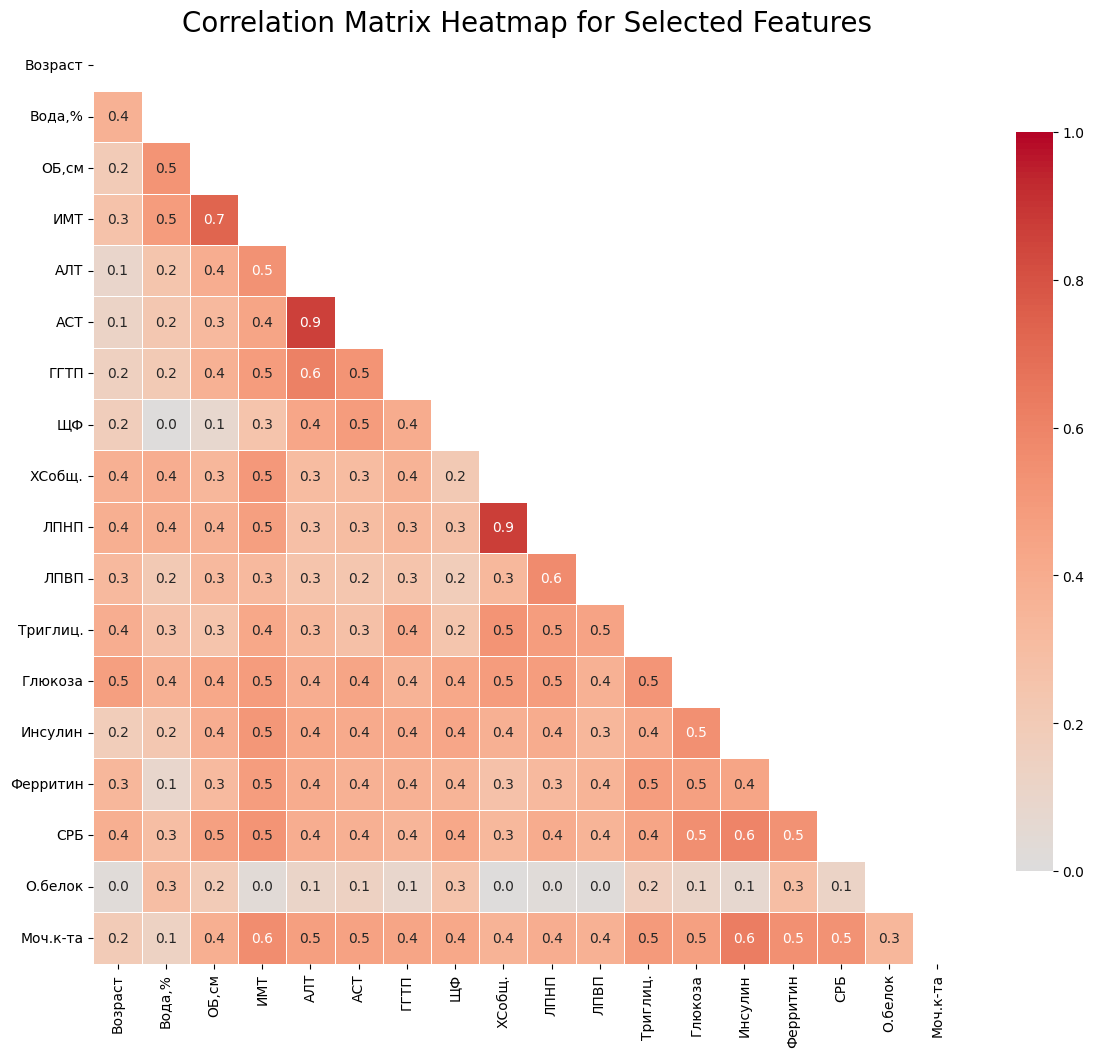

In [47]:
# Filter the DataFrame to include only the selected features
filtered_df = combined_df[best_features]

# Compute the absolute correlation matrix
correlation_matrix = filtered_df.corr().abs()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))  # Bigger figure size

# Draw the heatmap with the mask
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.1f',
                      linewidths=0.5, vmin=0, vmax=1, mask=mask,
                      cbar_kws={"shrink": .8})  # Add colorbar with smaller shrinkage

# Adjust font size
plt.title('Correlation Matrix Heatmap for Selected Features', size=20)  # Bigger title
plt.xticks(size=10)  # Smaller x-axis labels
plt.yticks(size=10)  # Smaller y-axis labels

# Display the plot
plt.show()

### Model with selecte features + standartization

In [48]:
# Selected features
selected_features = best_features

# Separate features and target
X = combined_df[selected_features]
y = combined_df['Group']

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_normalized, y)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        37
           1       0.94      0.83      0.88        35

    accuracy                           0.89        72
   macro avg       0.89      0.89      0.89        72
weighted avg       0.89      0.89      0.89        72



In [ ]:
# Evaluate feature importance in logistic regression
importances = model.coef_[0]
feature_importance = pd.Series(importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", feature_importance)

# Adjust coefficients to reflect the original scale
intercept = model.intercept_
coefficients = model.coef_[0]

# Adjust coefficients based on the scaler
adjusted_coefficients = coefficients / scaler.scale_
adjusted_intercept = intercept - np.sum((scaler.mean_ / scaler.scale_) * coefficients)

print(f'\nAdjusted Intercept: {adjusted_intercept}')
print(f'\nAdjusted Coefficients: {adjusted_coefficients}')

# Display regression equation
equation = f"NLFD Prediction = {adjusted_intercept[0]} "
for coef, feature in zip(adjusted_coefficients, selected_features):
    equation += f"+ ({coef} * {feature}) "
print(f'\nRegression Equation: {equation}')

Feature Importances:
 АЛТ         2.217510
АСТ         1.326454
ИМТ         1.293499
ГГТП        1.047364
Моч.к-та    0.767122
ХСобщ.      0.645615
ОБ,см       0.595769
ЩФ          0.339665
Триглиц.    0.264766
СРБ        -0.019475
Глюкоза    -0.078182
ЛПВП       -0.168647
Инсулин    -0.279961
Ферритин   -0.595700
Вода,%     -0.621175
Возраст    -0.782200
ЛПНП       -1.106663
О.белок    -1.233156
dtype: float64

Adjusted Intercept: [0.97018323]

Adjusted Coefficients: [-0.08072219 -0.13235429  0.07017954  0.30703425  0.09921889  0.08021237
  0.05570663  0.01532023  0.75921496 -1.07056487 -0.46508156  0.31828527
 -0.1219454  -0.03920512 -0.00449437 -0.00783805 -0.23358184  0.00737954]

Regression Equation: NLFD Prediction = 0.970183225705822 + (-0.08072219465413848 * Возраст) + (-0.1323542936747224 * Вода,%) + (0.0701795367692182 * ОБ,см) + (0.30703425454321354 * ИМТ) + (0.09921888903726948 * АЛТ) + (0.08021237043378888 * АСТ) + (0.055706634547376545 * ГГТП) + (0.01532022865002573 * ЩФ)

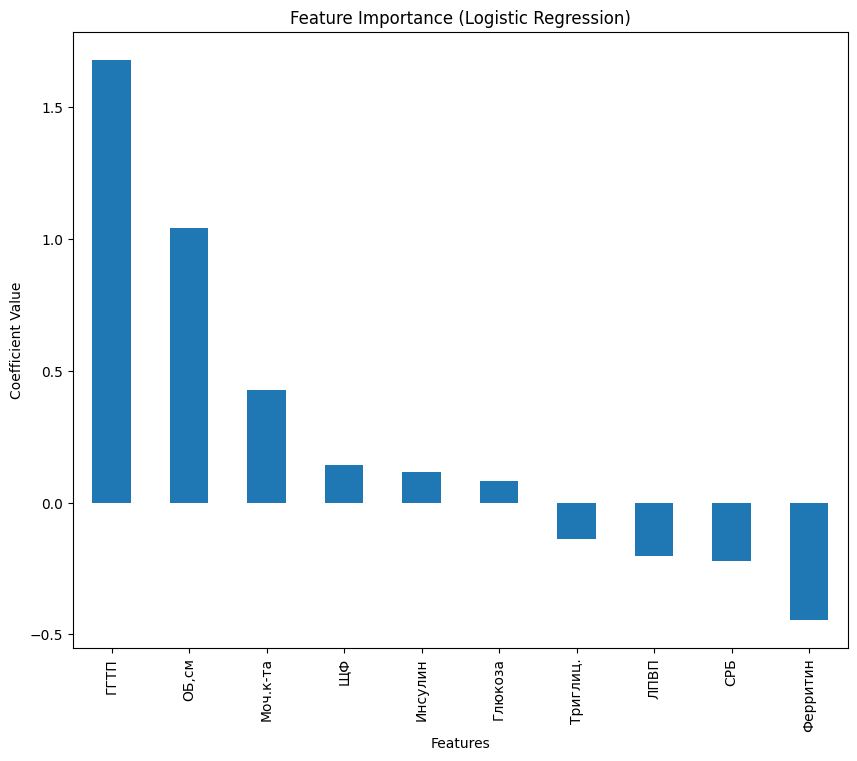

In [ ]:
plt.figure(figsize=(10, 8))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

In [ ]:
def calculate_nlfd_prediction(age, water, ob_sm, ast, ggtp, shf, lpvp, triglyc, glucose, insulin, ferritin, crb, uric_acid):
    # Define the coefficients from the regression equation
    intercept = -5.421066848582185
    coefficients = {
        'Возраст': -0.06509373369732464,
        'Вода,%': -0.17554066261143356,
        'ОБ,см': 0.09460989753365498,
        'АСТ': 0.14550569646818545,
        'ГГТП': 0.06779493212863329,
        'ЩФ': 0.0026030293715542776,
        'ЛПВП': 0.2598572047980786,
        'Триглиц.': 0.12273007714495547,
        'Глюкоза': -0.09116393396371184,
        'Инсулин': 0.003938323934870056,
        'Ферритин': -0.0018760460017536282,
        'СРБ': 0.027384640575055314,
        'Моч.к-та': 0.001223334236025924
    }

    # Calculate the prediction using the provided values
    prediction = intercept
    prediction += coefficients['Возраст'] * age
    prediction += coefficients['Вода,%'] * water
    prediction += coefficients['ОБ,см'] * ob_sm
    prediction += coefficients['АСТ'] * ast
    prediction += coefficients['ГГТП'] * ggtp
    prediction += coefficients['ЩФ'] * shf
    prediction += coefficients['ЛПВП'] * lpvp
    prediction += coefficients['Триглиц.'] * triglyc
    prediction += coefficients['Глюкоза'] * glucose
    prediction += coefficients['Инсулин'] * insulin
    prediction += coefficients['Ферритин'] * ferritin
    prediction += coefficients['СРБ'] * crb
    prediction += coefficients['Моч.к-та'] * uric_acid

    # Apply the sigmoid function to transform the result to a probability between 0 and 1
    from scipy.special import expit
    p_value = expit(prediction)

    return p_value

def main():
    # Input values from the user
    age = float(input("Введите значение для Возраст: "))
    water = float(input("Введите значение для Вода,%: "))
    ob_sm = float(input("Введите значение для ОБ,см: "))
    ast = float(input("Введите значение для АСТ: "))
    ggtp = float(input("Введите значение для ГГТП: "))
    shf = float(input("Введите значение для ЩФ: "))
    lpvp = float(input("Введите значение для ЛПВП: "))
    triglyc = float(input("Введите значение для Триглиц.: "))
    glucose = float(input("Введите значение для Глюкоза: "))
    insulin = float(input("Введите значение для Инсулин: "))
    ferritin = float(input("Введите значение для Ферритин: "))
    crb = float(input("Введите значение для СРБ: "))
    uric_acid = float(input("Введите значение для Моч.к-та: "))

    # Calculate the prediction
    p_value = calculate_nlfd_prediction(age, water, ob_sm, ast, ggtp, shf, lpvp, triglyc, glucose, insulin, ferritin, crb, uric_acid)

    # Print the result
    print(f"NLFD Prediction probability (p) = {p_value:.4f}")

if __name__ == "__main__":
    main()

Введите значение для Возраст: 58
Введите значение для Вода,%: 38.3
Введите значение для ОБ,см: 114
Введите значение для АСТ: 46.8
Введите значение для ГГТП: 39.6
Введите значение для ЩФ: 69
Введите значение для ЛПВП: 1.24
Введите значение для Триглиц.: 3.28
Введите значение для Глюкоза: 6.2
Введите значение для Инсулин: 26.8
Введите значение для Ферритин: 327.4
Введите значение для СРБ: 7.2
Введите значение для Моч.к-та: 397.5
NLFD Prediction probability (p) = 0.9924


### Same without Insulin

In [ ]:
# Define the best features excluding 'Инсулин'
selected_features = ['Возраст', 'Вода,%', 'ОБ,см', 'АСТ', 'ГГТП', 'ЩФ', 'ЛПВП', 'Триглиц.', 'Глюкоза', 'Ферритин', 'СРБ', 'Моч.к-та']

# Separate features and target
X = combined_df[selected_features]
y = combined_df['Group']

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_normalized, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.85      0.80      0.82        35

    accuracy                           0.83        72
   macro avg       0.83      0.83      0.83        72
weighted avg       0.83      0.83      0.83        72



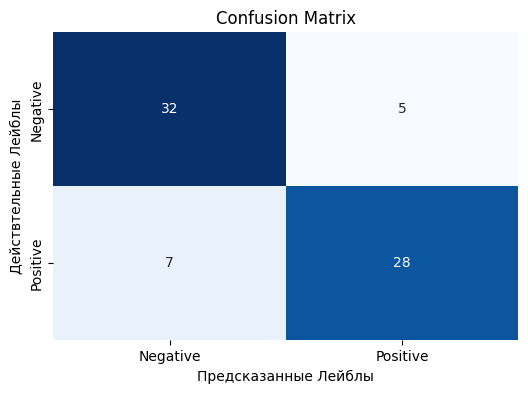

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанные Лейблы')
plt.ylabel('Действтельные Лейблы')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate feature importance in logistic regression
importances = model.coef_[0]
feature_importance = pd.Series(importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", feature_importance)

# Adjust coefficients to reflect the original scale
intercept = model.intercept_
coefficients = model.coef_[0]

# Adjust coefficients based on the scaler
adjusted_coefficients = coefficients / scaler.scale_
adjusted_intercept = intercept - np.sum((scaler.mean_ / scaler.scale_) * coefficients)

print(f'\nAdjusted Intercept: {adjusted_intercept}')
print(f'\nAdjusted Coefficients: {adjusted_coefficients}')


Feature Importances:
 АСТ         2.459092
ГГТП        1.279452
ОБ,см       0.799488
Моч.к-та    0.135015
Триглиц.    0.088755
ЛПВП        0.080504
ЩФ          0.057727
СРБ         0.056614
Глюкоза    -0.091911
Ферритин   -0.238462
Возраст    -0.606204
Вода,%     -0.860568
dtype: float64

Adjusted Intercept: [-4.80458174]

Adjusted Coefficients: [-0.06255957 -0.18336185  0.09417697  0.14870444  0.06805077  0.0026037
  0.22200817  0.10669549 -0.14335935 -0.00179912  0.02278571  0.00129882]



Regression Equation: NLFD Prediction = -4.80458173575915 + (-0.06255957169222563 * Возраст) + (-0.18336184536619551 * Вода,%) + (0.09417696828243437 * ОБ,см) + (0.14870443677498993 * АСТ) + (0.06805077475941315 * ГГТП) + (0.0026037003017784946 * ЩФ) + (0.22200816698799253 * ЛПВП) + (0.1066954909253985 * Триглиц.) + (-0.14335935464306612 * Глюкоза) + (-0.0017991231708034488 * Ферритин) + (0.022785710084822646 * СРБ) + (0.001298817067548743 * Моч.к-та) 


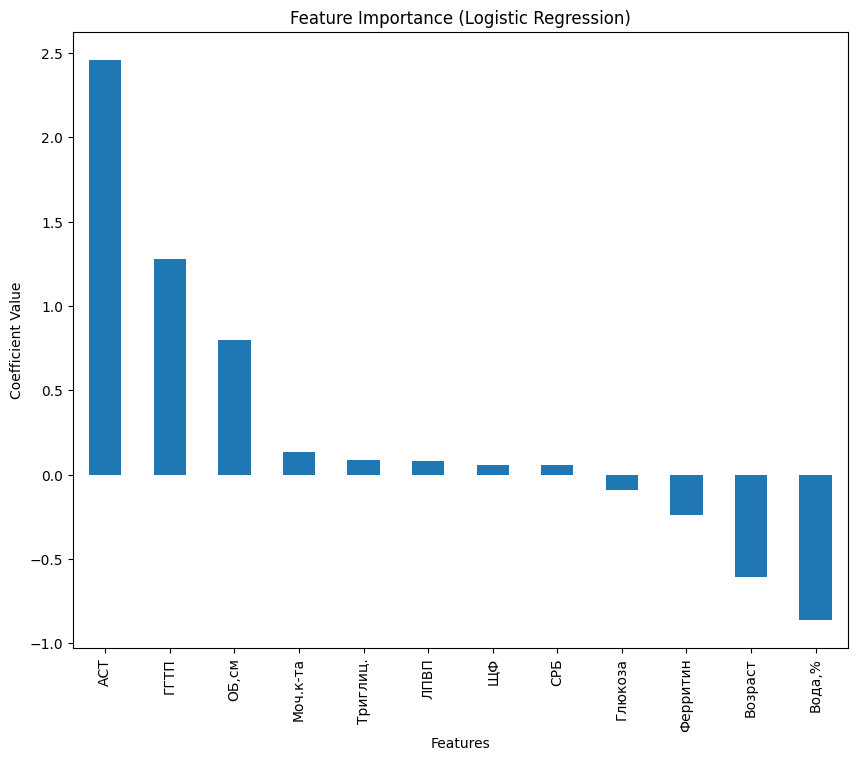

In [ ]:
# Display regression equation
equation = f"NLFD Prediction = {adjusted_intercept[0]} "
for coef, feature in zip(adjusted_coefficients, selected_features):
    equation += f"+ ({coef} * {feature}) "
print(f'\nRegression Equation: {equation}')

# Plot feature importance
plt.figure(figsize=(10, 8))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

In [ ]:
# Function to calculate NLFD Prediction
def calculate_nlfd_prediction(age, water, ob_sm, ast, ggtp, shf, lpvp, triglyc, glucose, ferritin, crb, uric_acid):
    # Define the coefficients from the regression equation
    intercept = adjusted_intercept[0]
    coefficients = {
        'Возраст': adjusted_coefficients[0],
        'Вода,%': adjusted_coefficients[1],
        'ОБ,см': adjusted_coefficients[2],
        'АСТ': adjusted_coefficients[3],
        'ГГТП': adjusted_coefficients[4],
        'ЩФ': adjusted_coefficients[5],
        'ЛПВП': adjusted_coefficients[6],
        'Триглиц.': adjusted_coefficients[7],
        'Глюкоза': adjusted_coefficients[8],
        'Ферритин': adjusted_coefficients[9],
        'СРБ': adjusted_coefficients[10],
        'Моч.к-та': adjusted_coefficients[11]
    }

    # Calculate the prediction using the provided values
    prediction = intercept
    prediction += coefficients['Возраст'] * age
    prediction += coefficients['Вода,%'] * water
    prediction += coefficients['ОБ,см'] * ob_sm
    prediction += coefficients['АСТ'] * ast
    prediction += coefficients['ГГТП'] * ggtp
    prediction += coefficients['ЩФ'] * shf
    prediction += coefficients['ЛПВП'] * lpvp
    prediction += coefficients['Триглиц.'] * triglyc
    prediction += coefficients['Глюкоза'] * glucose
    prediction += coefficients['Ферритин'] * ferritin
    prediction += coefficients['СРБ'] * crb
    prediction += coefficients['Моч.к-та'] * uric_acid

    #from scipy.special import expit
    p_value = expit(prediction)

    return p_value
3
def main():
    # Input values from the user
    age = float(input("Введите значение для Возраст: "))
    water = float(input("Введите значение для Вода,%: "))
    ob_sm = float(input("Введите значение для ОБ,см: "))
    ast = float(input("Введите значение для АСТ: "))
    ggtp = float(input("Введите значение для ГГТП: "))
    shf = float(input("Введите значение для ЩФ: "))
    lpvp = float(input("Введите значение для ЛПВП: "))
    triglyc = float(input("Введите значение для Триглиц.: "))
    glucose = float(input("Введите значение для Глюкоза: "))
    ferritin = float(input("Введите значение для Ферритин: "))
    crb = float(input("Введите значение для СРБ: "))
    uric_acid = float(input("Введите значение для Моч.к-та: "))

    # Calculate the prediction
    p_value = calculate_nlfd_prediction(age, water, ob_sm, ast, ggtp, shf, lpvp, triglyc, glucose, ferritin, crb, uric_acid)

    # Print the result
    print(f"NLFD Prediction probability (p) = {p_value:.4f}")

if __name__ == "__main__":
    main()

Введите значение для Возраст: 33
Введите значение для Вода,%: 3
Введите значение для ОБ,см: 3
Введите значение для АСТ: 3
Введите значение для ГГТП: 3
Введите значение для ЩФ: 3
Введите значение для ЛПВП: 33
Введите значение для Триглиц.: 3
Введите значение для Глюкоза: 3
Введите значение для Ферритин: 3
Введите значение для СРБ: 33
Введите значение для Моч.к-та: 33
NLFD Prediction probability (p) = 0.8216


In [ ]:
def calculate_nlfd_prediction(age, water, ob_sm, ast, ggtp, shf, lpvp, triglyc, glucose, ferritin, crb, uric_acid):

    intercept = adjusted_intercept[0]

    coefficients = {
        'Возраст': adjusted_coefficients[0],
        'Вода,%': adjusted_coefficients[1],
        'ОБ,см': adjusted_coefficients[2],
        'АСТ': adjusted_coefficients[3],
        'ГГТП': adjusted_coefficients[4],
        'ЩФ': adjusted_coefficients[5],
        'ЛПВП': adjusted_coefficients[6],
        'Триглиц.': adjusted_coefficients[7],
        'Глюкоза': adjusted_coefficients[8],
        'Ферритин': adjusted_coefficients[9],
        'СРБ': adjusted_coefficients[10],
        'Моч.к-та': adjusted_coefficients[11]
    }

    # Вычислите предсказание на основе введенных значений
    prediction = intercept
    prediction += coefficients['Возраст'] * age
    prediction += coefficients['Вода,%'] * water
    prediction += coefficients['ОБ,см'] * ob_sm
    prediction += coefficients['АСТ'] * ast
    prediction += coefficients['ГГТП'] * ggtp
    prediction += coefficients['ЩФ'] * shf
    prediction += coefficients['ЛПВП'] * lpvp
    prediction += coefficients['Триглиц.'] * triglyc
    prediction += coefficients['Глюкоза'] * glucose
    prediction += coefficients['Ферритин'] * ferritin
    prediction += coefficients['СРБ'] * crb
    prediction += coefficients['Моч.к-та'] * uric_acid

    # Примените функцию сигмоида для преобразования результата в вероятность от 0 до 1
    p_value = expit(prediction)

    return p_value

df = dataframes[0]  # Предположим, что это ваш DataFrame

# Выберите нужные столбцы
selected_columns = ['Возраст', 'Вода,%', 'ОБ,см', 'АСТ', 'ГГТП', 'ЩФ', 'ЛПВП', 'Триглиц.', 'Глюкоза', 'Ферритин', 'СРБ', 'Моч.к-та']

# Проверьте, есть ли все нужные столбцы в DataFrame
for col in selected_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing from the DataFrame")

df['NLFD_Prediction'] = df.apply(lambda row: calculate_nlfd_prediction(
    row['Возраст'],
    row['Вода,%'],
    row['ОБ,см'],
    row['АСТ'],
    row['ГГТП'],
    row['ЩФ'],
    row['ЛПВП'],
    row['Триглиц.'],
    row['Глюкоза'],
    row['Ферритин'],
    row['СРБ'],
    row['Моч.к-та']
), axis=1)

print(df[['ФИО', 'NLFD_Prediction']])

                                ФИО  NLFD_Prediction
0      Чаликова Виктория Валерьевна         0.893100
1   Сидорова Екатерина Владимировна         0.579591
2        Кузнецова Ольга Николаевна         0.994138
3            Попов Андрей Андреевич         0.721738
4         Андронова Марина Карловна         0.998675
5     Зайцева Светлана Вячеславовна         0.992910
6     Зайцев Александр Вячеславович         0.795565
7      Сальников Андрей Анатольевич         0.960828
8         Козлова Оксана Георгиевна         0.928297
9        Белякова Татьяна Борисовна         0.739512
10          Савва Дмитрий Андреевич         0.997665
11      Туфанов Дмитрий Анатольевич         0.999823
12        Виноградова Ольга Юрьевна         0.781136
13     Виноградов Сергей Николаевич         0.988225
14         Симакин Амаль Викторович         0.814350
15       Булавина Влада Андрияновна         0.320634
16         Посух Василий Васильевич         0.957270
17      Мещерякова Людмила Ивановна         0.

### Same without Ferritin

In [ ]:
# Define the best features excluding 'Инсулин'
selected_features = ['Возраст', 'Вода,%', 'ОБ,см', 'АСТ', 'ГГТП', 'ЩФ', 'ЛПВП', 'Триглиц.', 'Глюкоза', 'Инсулин', 'СРБ', 'Моч.к-та']

# Separate features and target
X = combined_df[selected_features]
y = combined_df['Group']

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_normalized, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8611111111111112
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        37
           1       0.86      0.86      0.86        35

    accuracy                           0.86        72
   macro avg       0.86      0.86      0.86        72
weighted avg       0.86      0.86      0.86        72



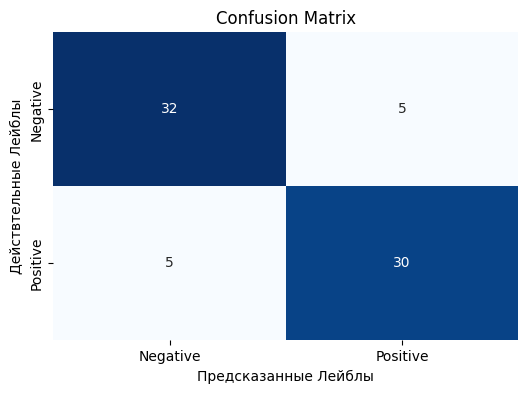

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанные Лейблы')
plt.ylabel('Действтельные Лейблы')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate feature importance in logistic regression
importances = model.coef_[0]
feature_importance = pd.Series(importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", feature_importance)

# Adjust coefficients to reflect the original scale
intercept = model.intercept_
coefficients = model.coef_[0]

# Adjust coefficients based on the scaler
adjusted_coefficients = coefficients / scaler.scale_
adjusted_intercept = intercept - np.sum((scaler.mean_ / scaler.scale_) * coefficients)

print(f'\nAdjusted Intercept: {adjusted_intercept}')
print(f'\nAdjusted Coefficients: {adjusted_coefficients}')


Feature Importances:
 АСТ         2.425204
ГГТП        1.161559
ОБ,см       0.821532
ЛПВП        0.162830
Триглиц.    0.137347
ЩФ          0.082917
Моч.к-та    0.066410
СРБ         0.026649
Инсулин    -0.052332
Глюкоза    -0.077900
Возраст    -0.676552
Вода,%     -0.870144
dtype: float64

Adjusted Intercept: [-5.00539785]

Adjusted Coefficients: [-0.06981945 -0.18540215  0.09677368  0.14665519  0.06178033  0.00373989
  0.44904203  0.16511039 -0.12150596 -0.00732848  0.01072543  0.00063885]


In [ ]:
# Определите список выбранных признаков
selected_features = ['Возраст', 'Вода,%', 'ОБ,см', 'АСТ', 'ГГТП', 'ЩФ', 'ЛПВП', 'Триглиц.', 'Глюкоза', 'Инсулин', 'СРБ', 'Моч.к-та']

# Оцените важность признаков в логистической регрессии
importances = model.coef_[0]
feature_importance = pd.Series(importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", feature_importance)

# Откорректируйте коэффициенты в соответствии с масштабом
intercept = model.intercept_
coefficients = model.coef_[0]

# Откорректируйте коэффициенты на основе масштабировщика
adjusted_coefficients = coefficients / scaler.scale_
adjusted_intercept = intercept - np.sum((scaler.mean_ / scaler.scale_) * coefficients)

# Создайте Series для откорректированных коэффициентов с правильным порядком
adjusted_feature_importance = pd.Series(adjusted_coefficients, index=selected_features)

print(f'\nAdjusted Intercept: {adjusted_intercept}')
print(f'\nAdjusted Coefficients:\n{adjusted_feature_importance}')


Feature Importances:
 АСТ         2.425204
ГГТП        1.161559
ОБ,см       0.821532
ЛПВП        0.162830
Триглиц.    0.137347
ЩФ          0.082917
Моч.к-та    0.066410
СРБ         0.026649
Инсулин    -0.052332
Глюкоза    -0.077900
Возраст    -0.676552
Вода,%     -0.870144
dtype: float64

Adjusted Intercept: [-5.00539785]

Adjusted Coefficients:
Возраст    -0.069819
Вода,%     -0.185402
ОБ,см       0.096774
АСТ         0.146655
ГГТП        0.061780
ЩФ          0.003740
ЛПВП        0.449042
Триглиц.    0.165110
Глюкоза    -0.121506
Инсулин    -0.007328
СРБ         0.010725
Моч.к-та    0.000639
dtype: float64



Regression Equation: NLFD Prediction = -5.005397854747484 + (-0.06981945326045687 * Возраст) + (-0.1854021508901687 * Вода,%) + (0.0967736832391247 * ОБ,см) + (0.14665519457329795 * АСТ) + (0.061780329529438016 * ГГТП) + (0.0037398944901428834 * ЩФ) + (0.4490420299650244 * ЛПВП) + (0.16511039299127936 * Триглиц.) + (-0.12150595853444097 * Глюкоза) + (-0.007328477122791528 * Инсулин) + (0.010725427953490818 * СРБ) + (0.0006388470953869965 * Моч.к-та) 


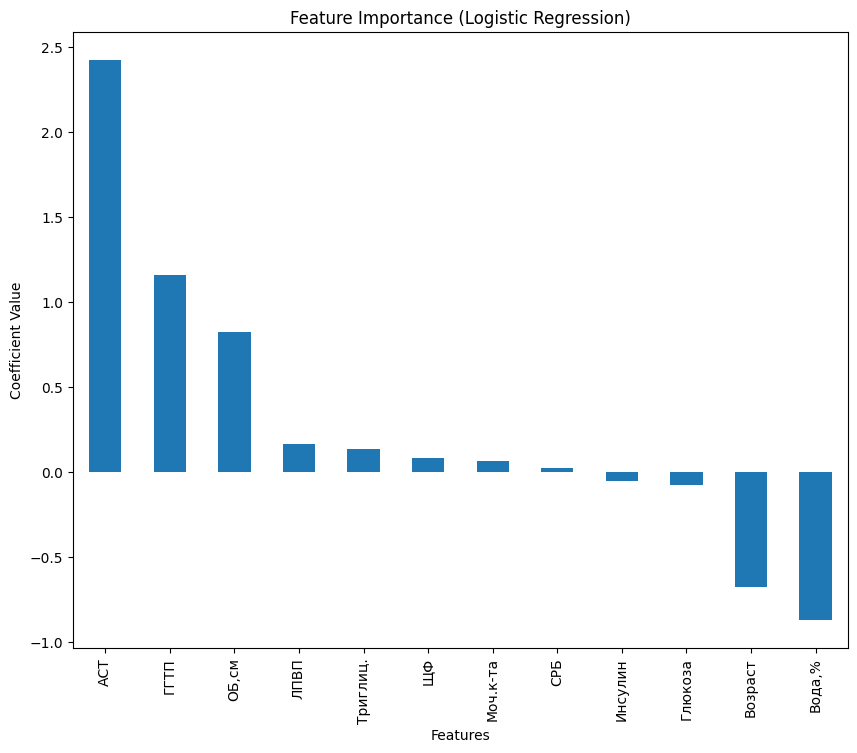

In [ ]:
# Display regression equation
equation = f"NLFD Prediction = {adjusted_intercept[0]} "
for coef, feature in zip(adjusted_coefficients, selected_features):
    equation += f"+ ({coef} * {feature}) "
print(f'\nRegression Equation: {equation}')

# Plot feature importance
plt.figure(figsize=(10, 8))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

In [ ]:
# Function to calculate NLFD Prediction
def calculate_nlfd_prediction(age, water, ob_sm, ast, ggtp, shf, lpvp, triglyc, glucose, insulin, crb, uric_acid):
    # Define the coefficients from the regression equation
    intercept = adjusted_intercept[0]
    coefficients = {
        'Возраст': adjusted_coefficients[0],
        'Вода,%': adjusted_coefficients[1],
        'ОБ,см': adjusted_coefficients[2],
        'АСТ': adjusted_coefficients[3],
        'ГГТП': adjusted_coefficients[4],
        'ЩФ': adjusted_coefficients[5],
        'ЛПВП': adjusted_coefficients[6],
        'Триглиц.': adjusted_coefficients[7],
        'Глюкоза': adjusted_coefficients[8],
        'Инсулин': adjusted_coefficients[9],
        'СРБ': adjusted_coefficients[10],
        'Моч.к-та': adjusted_coefficients[11]
    }

    # Calculate the prediction using the provided values
    prediction = intercept
    prediction += coefficients['Возраст'] * age
    prediction += coefficients['Вода,%'] * water
    prediction += coefficients['ОБ,см'] * ob_sm
    prediction += coefficients['АСТ'] * ast
    prediction += coefficients['ГГТП'] * ggtp
    prediction += coefficients['ЩФ'] * shf
    prediction += coefficients['ЛПВП'] * lpvp
    prediction += coefficients['Триглиц.'] * triglyc
    prediction += coefficients['Глюкоза'] * glucose
    prediction += coefficients['Инсулин'] * insulin
    prediction += coefficients['СРБ'] * crb
    prediction += coefficients['Моч.к-та'] * uric_acid

    #from scipy.special import expit
    p_value = expit(prediction)

    return p_value
3
def main():
    # Input values from the user
    age = float(input("Введите значение для Возраст: "))
    water = float(input("Введите значение для Вода,%: "))
    ob_sm = float(input("Введите значение для ОБ,см: "))
    ast = float(input("Введите значение для АСТ: "))
    ggtp = float(input("Введите значение для ГГТП: "))
    shf = float(input("Введите значение для ЩФ: "))
    lpvp = float(input("Введите значение для ЛПВП: "))
    triglyc = float(input("Введите значение для Триглиц.: "))
    glucose = float(input("Введите значение для Глюкоза: "))
    insulin = float(input("Введите значение для Инсулина: "))
    crb = float(input("Введите значение для СРБ: "))
    uric_acid = float(input("Введите значение для Моч.к-та: "))

    # Calculate the prediction
    p_value = calculate_nlfd_prediction(age, water, ob_sm, ast, ggtp, shf, lpvp, triglyc, glucose, insulin, crb, uric_acid)

    # Print the result
    print(f"NLFD Prediction probability (p) = {p_value:.4f}")

if __name__ == "__main__":
    main()

In [ ]:
def calculate_nlfd_prediction(age, water, ob_sm, ast, ggtp, shf, lpvp, triglyc, glucose, insulin, crb, uric_acid):

    intercept = adjusted_intercept[0]

    coefficients = {
        'Возраст': adjusted_coefficients[0],
        'Вода,%': adjusted_coefficients[1],
        'ОБ,см': adjusted_coefficients[2],
        'АСТ': adjusted_coefficients[3],
        'ГГТП': adjusted_coefficients[4],
        'ЩФ': adjusted_coefficients[5],
        'ЛПВП': adjusted_coefficients[6],
        'Триглиц.': adjusted_coefficients[7],
        'Глюкоза': adjusted_coefficients[8],
        'Инсулин': adjusted_coefficients[9],
        'СРБ': adjusted_coefficients[10],
        'Моч.к-та': adjusted_coefficients[11]
    }

    # Вычислите предсказание на основе введенных значений
    prediction = intercept
    prediction += coefficients['Возраст'] * age
    prediction += coefficients['Вода,%'] * water
    prediction += coefficients['ОБ,см'] * ob_sm
    prediction += coefficients['АСТ'] * ast
    prediction += coefficients['ГГТП'] * ggtp
    prediction += coefficients['ЩФ'] * shf
    prediction += coefficients['ЛПВП'] * lpvp
    prediction += coefficients['Триглиц.'] * triglyc
    prediction += coefficients['Глюкоза'] * glucose
    prediction += coefficients['Инсулин'] * insulin
    prediction += coefficients['СРБ'] * crb
    prediction += coefficients['Моч.к-та'] * uric_acid

    # Примените функцию сигмоида для преобразования результата в вероятность от 0 до 1
    p_value = expit(prediction)

    return p_value

df = dataframes[6]  # Предположим, что это ваш DataFrame

# Выберите нужные столбцы
selected_columns = ['Возраст', 'Вода,%', 'ОБ,см', 'АСТ', 'ГГТП', 'ЩФ', 'ЛПВП', 'Триглиц.', 'Глюкоза', 'Инсулин', 'СРБ', 'Моч.к-та']

# Проверьте, есть ли все нужные столбцы в DataFrame
for col in selected_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing from the DataFrame")

df['NLFD_Prediction'] = df.apply(lambda row: calculate_nlfd_prediction(
    row['Возраст'],
    row['Вода,%'],
    row['ОБ,см'],
    row['АСТ'],
    row['ГГТП'],
    row['ЩФ'],
    row['ЛПВП'],
    row['Триглиц.'],
    row['Глюкоза'],
    row['Инсулин'],
    row['СРБ'],
    row['Моч.к-та']
), axis=1)

#print(df[['ФИО', 'NLFD_Prediction']])

### Different trial



In [ ]:
# Define features and target
features = ['Пол', 'Возраст', 'О.ж.,%', 'Висц.ж,%', 'Мыш.м,%', 'Скелет,%', 'Кости,кг', 'Вода,%', 'СООВ,ккал', 'ОГ,см',
            'ОТ,см', 'ОЖ,см', 'ОБ,см', 'ИМТ', 'АЛТ', 'АСТ', 'ГГТП', 'ЩФ', 'ХСобщ.', 'ЛПНП', 'ЛПВП', 'Триглиц.',
            'Билир.о', 'Билир.пр', 'Глюкоза', 'Инсулин', 'Ферритин', 'СРБ', 'О.белок', 'Моч.к-та']

target = 'Group'

X = combined_df[features]
y = combined_df[target]

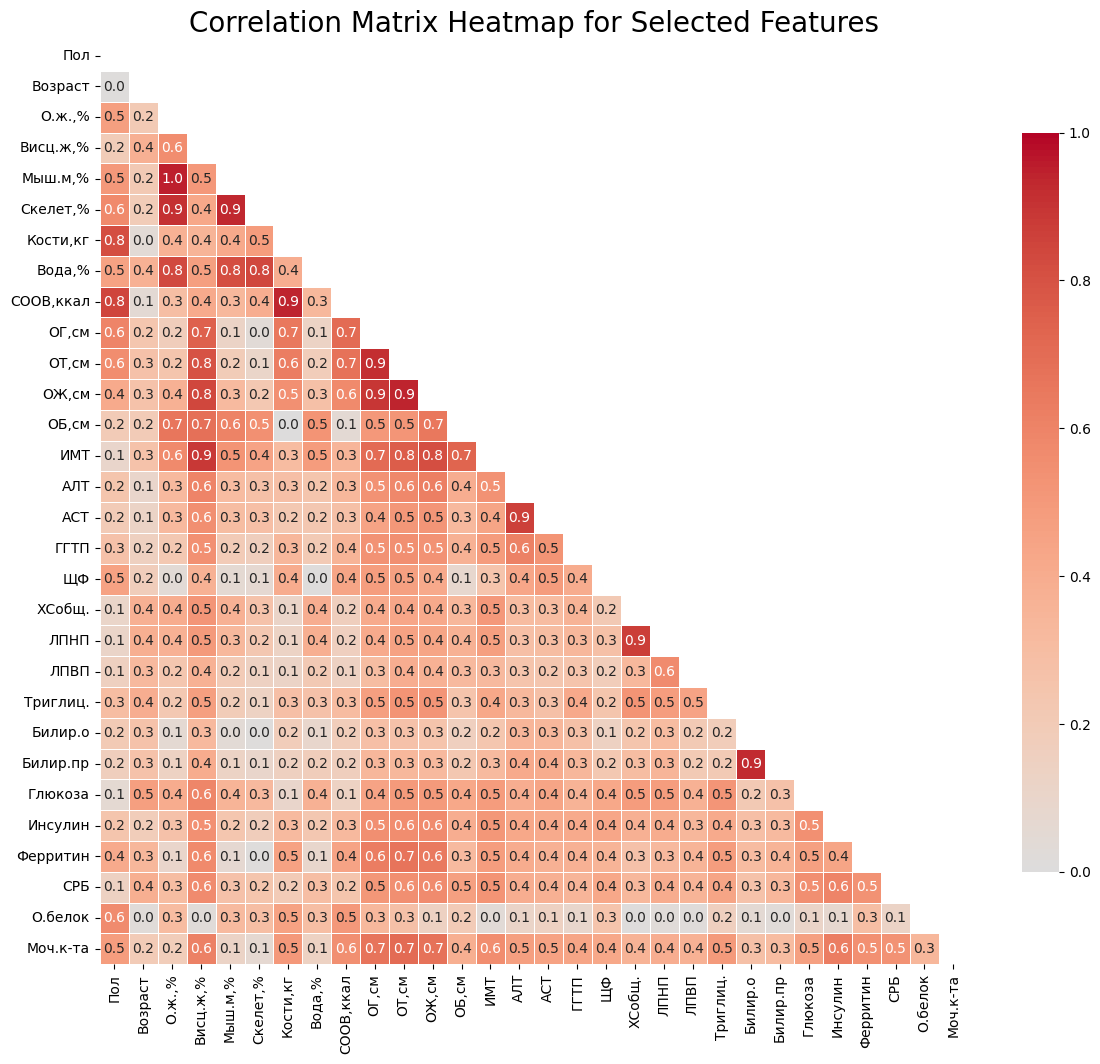

In [ ]:
correlation_matrix = X.corr().abs()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))  # Bigger figure size

# Draw the heatmap with the mask
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.1f',
                      linewidths=0.5, vmin=0, vmax=1, mask=mask,
                      cbar_kws={"shrink": .8})  # Add colorbar with smaller shrinkage

# Adjust font size
plt.title('Correlation Matrix Heatmap for Selected Features', size=20)  # Bigger title
plt.xticks(size=10)  # Smaller x-axis labels
plt.yticks(size=10)  # Smaller y-axis labels

# Display the plot
plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Identify and drop highly correlated features
threshold = 0.9  # Higher threshold for high correlation
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
X_reduced = X.drop(columns=to_drop)

print(f"Removed features: {to_drop}")

Removed features: ['Скелет,%', 'СООВ,ккал', 'ОТ,см', 'ОЖ,см', 'Билир.пр']


In [ ]:
# Функция для расчета VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Расчет начального VIF
vif_data = calculate_vif(X_reduced)

# Печать начального VIF
print("Initial VIF values:")
print(vif_data)

# Удаление признаков с высоким VIF и пересчет
while vif_data['VIF'].max() > 10:  # Порог VIF
    feature_to_drop = vif_data.sort_values('VIF', ascending=False)['Feature'].iloc[0]
    X_reduced = X_reduced.drop(columns=[feature_to_drop])
    vif_data = calculate_vif(X_reduced)

# Печать финальных признаков и их VIF
print(f"\nFinal selected features after VIF correction: {X_reduced.columns.tolist()}")
print("\nFinal VIF values:")
print(vif_data)


Initial VIF values:
    Feature        VIF
0       Пол   2.617476
1       АСТ   7.663226
2      ГГТП   7.489911
3      ЛПНП  14.701768
4      ЛПВП   7.374776
5  Триглиц.   7.650004
6   Билир.о   5.289948
7   Инсулин  11.800610
8  Ферритин   4.683946
9       СРБ   4.685125

Final selected features after VIF correction: ['Пол', 'АСТ', 'ГГТП', 'ЛПВП', 'Триглиц.', 'Билир.о', 'Ферритин', 'СРБ']

Final VIF values:
    Feature       VIF
0       Пол  2.425377
1       АСТ  7.411016
2      ГГТП  7.288521
3      ЛПВП  6.402376
4  Триглиц.  6.095263
5   Билир.о  4.850100
6  Ферритин  4.661206
7       СРБ  3.949796


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5)

rfe = RFE(model, n_features_to_select=12)  # Increase number of features selected by RFE
fit = rfe.fit(X_train, y_train)

selected_features = X_reduced.columns[fit.support_]
print(f"Selected features: {selected_features}")

Selected features: Index(['Пол', 'АСТ', 'ГГТП', 'ЛПВП', 'Триглиц.', 'Билир.о', 'Ферритин', 'СРБ'], dtype='object')


In [ ]:
model.fit(X_train[:, fit.support_], y_train)

coefficients = model.coef_[0]
intercept = model.intercept_[0]

coefficients_adjusted = coefficients / scaler.scale_[fit.support_]
intercept_adjusted = intercept - np.sum(coefficients * scaler.mean_[fit.support_] / scaler.scale_[fit.support_])

adjusted_coefs_series = pd.Series(coefficients_adjusted, index=selected_features)

regression_equation = f'Logit(P) = {intercept_adjusted:.4f}'
for feature, coef in adjusted_coefs_series.items():
    regression_equation += f' + ({coef:.4f} * {feature})'

print("Adjusted Coefficients:")
print(adjusted_coefs_series)
print("\nRegression Equation:")
print(regression_equation)

Adjusted Coefficients:
Пол         1.335932
АСТ         0.157455
ГГТП        0.093585
ЛПВП       -0.467491
Триглиц.    0.102368
Билир.о    -0.049494
Ферритин    0.000000
СРБ        -0.072655
dtype: float64

Regression Equation:
Logit(P) = -5.8928 + (1.3359 * Пол) + (0.1575 * АСТ) + (0.0936 * ГГТП) + (-0.4675 * ЛПВП) + (0.1024 * Триглиц.) + (-0.0495 * Билир.о) + (0.0000 * Ферритин) + (-0.0727 * СРБ)


In [ ]:
len(X_test)

36

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

scores = cross_val_score(model, X_scaled[:, fit.support_], y, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

coefficients = model.coef_[0]
features = X_reduced.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)
print(importance_df)

Cross-validation scores: [0.91666667 0.77777778 0.88888889 0.86111111 0.80555556]
Mean cross-validation score: 0.85
Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.95      0.88      0.91        24

    accuracy                           0.89        36
   macro avg       0.87      0.90      0.88        36
weighted avg       0.90      0.89      0.89        36

    Feature  Coefficient  Absolute Coefficient
1       АСТ     2.603801              2.603801
2      ГГТП     1.759536              1.759536
0       Пол     0.666480              0.666480
5   Билир.о    -0.304254              0.304254
7       СРБ    -0.180519              0.180519
3      ЛПВП    -0.169520              0.169520
4  Триглиц.     0.085155              0.085155
6  Ферритин     0.000000              0.000000


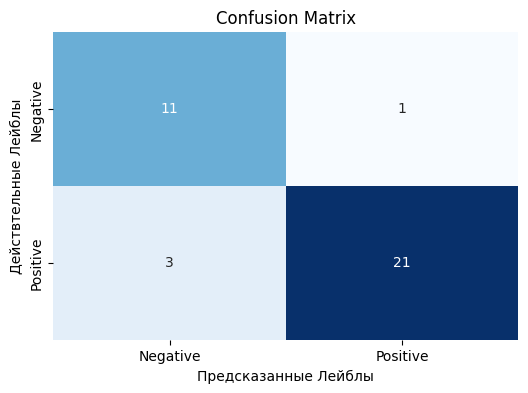

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанные Лейблы')
plt.ylabel('Действтельные Лейблы')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Assuming you have trained your model as shown in your previous code
coefficients = model.coef_[0]
features = X_reduced.columns

# Create a DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient values
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

print(importance_df)

    Feature  Coefficient  Absolute Coefficient
1       АСТ     2.603801              2.603801
2      ГГТП     1.759536              1.759536
0       Пол     0.666480              0.666480
5   Билир.о    -0.304254              0.304254
7       СРБ    -0.180519              0.180519
3      ЛПВП    -0.169520              0.169520
4  Триглиц.     0.085155              0.085155
6  Ферритин     0.000000              0.000000


## New Attempt - LOG REG with ELASTIC


**Coefficient Shrinking:**
The model assigns a weight (coefficient) to each feature. If a feature contributes a lot to predicting the target, its coefficient will be large. If it doesn’t contribute much, its coefficient will be small.

Penalties:

- L1 penalty (Lasso part): Adds a cost based on the size of the coefficients. If a feature’s coefficient is small, the L1 penalty may reduce it all the way to zero. A coefficient of zero means the feature is ignored or "eliminated" from the model because it’s considered unimportant.


- L2 penalty (Ridge part): Shrinks the coefficients of less important features but doesn’t set them to zero.

In [49]:
features = ['Пол', 'Возраст', 'О.ж.,%', 'Висц.ж,%', 'Мыш.м,%', 'Скелет,%',
            'Кости,кг', 'Вода,%', 'СООВ,ккал', 'ОГ,см', 'ОТ,см', 'ОЖ,см', 'ОБ,см',
            'ИМТ', 'АЛТ', 'АСТ', 'ГГТП', 'ЩФ', 'ХСобщ.', 'ЛПНП', 'ЛПВП', 'Триглиц.',
            'Билир.о', 'Билир.пр', 'Глюкоза', 'Инсулин', 'Ферритин', 'СРБ',
            'О.белок', 'Моч.к-та']
target = 'Group'

X = combined_df[features]
y = combined_df[target]

In [ ]:
#values = ['О.ж.,%', 'Висц.ж,%', 'Мыш.м,%', 'ИМТ', 'АЛТ', 'АСТ', 'ГГТП', 'О.белок']

In [54]:
X = combined_df[features]
y = combined_df['Group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg_elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000)  # Elastic Net
log_reg_elastic.fit(X_train_scaled, y_train)

y_test_pred_class = log_reg_elastic.predict(X_test_scaled)
y_test_pred_proba = log_reg_elastic.predict_proba(X_test_scaled)[:, 1]

Elastic Net Logistic Regression Test Accuracy: 0.9167
Confusion Matrix on Test Data:
[[10  2]
 [ 1 23]]


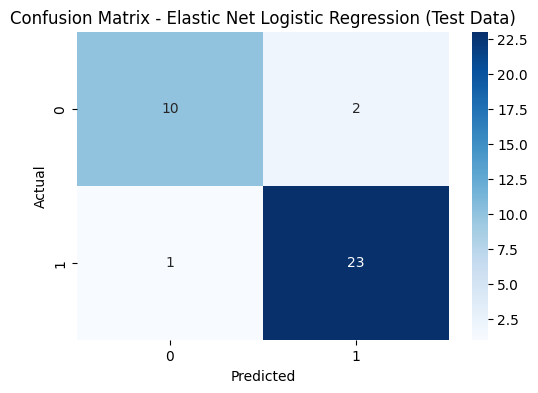


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.92      0.96      0.94        24

    accuracy                           0.92        36
   macro avg       0.91      0.90      0.90        36
weighted avg       0.92      0.92      0.92        36



In [55]:
cm_test = confusion_matrix(y_test, y_test_pred_class)
test_accuracy = accuracy_score(y_test, y_test_pred_class)

print(f"Elastic Net Logistic Regression Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix on Test Data:")
print(cm_test)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Elastic Net Logistic Regression (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred_class))

In [56]:

unscaled_coefficients = log_reg_elastic.coef_[0] / scaler.scale_

unscaled_intercept = log_reg_elastic.intercept_ - np.sum((scaler.mean_ / scaler.scale_) * log_reg_elastic.coef_[0])

unscaled_coefficients_series = pd.Series(unscaled_coefficients, index=X.columns)
print("Unscaled Coefficients:", unscaled_coefficients_series)
print("Unscaled Intercept:", unscaled_intercept)

def predict_with_unscaled(features):
    y_pred = unscaled_intercept.item()  # Ensure it's a scalar
    for feature, coef in zip(X.columns, unscaled_coefficients):
        y_pred += coef * features[feature]
    return y_pred

raw_predictions = combined_df.apply(predict_with_unscaled, axis=1)

predicted_probabilities = 1 / (1 + np.exp(-raw_predictions.to_numpy().flatten()))

predicted_classes = (predicted_probabilities >= 0.5).astype(int)

results_df = pd.DataFrame({
    'raw_prediction': raw_predictions,
    'predicted_probability': predicted_probabilities,
    'predicted_class': predicted_classes,
    'actual_class': combined_df['Group']
})

print(results_df.head())


cm = confusion_matrix(results_df['actual_class'], results_df['predicted_class'])
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(results_df['actual_class'], results_df['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(results_df['actual_class'], results_df['predicted_class'])
print("Classification Report:")
print(report)

Unscaled Coefficients: Пол          0.000000
Возраст     -0.052589
О.ж.,%       0.043718
Висц.ж,%     0.342829
Мыш.м,%     -0.113518
Скелет,%    -0.024138
Кости,кг     0.000000
Вода,%      -0.008819
СООВ,ккал   -0.000035
ОГ,см       -0.079265
ОТ,см        0.036202
ОЖ,см        0.020505
ОБ,см        0.000000
ИМТ          0.192689
АЛТ          0.102878
АСТ          0.067330
ГГТП         0.080977
ЩФ           0.020393
ХСобщ.       0.417386
ЛПНП        -0.692138
ЛПВП         0.000000
Триглиц.     0.000000
Билир.о     -0.035024
Билир.пр     0.078859
Глюкоза      0.112528
Инсулин      0.000000
Ферритин    -0.003887
СРБ         -0.149854
О.белок     -0.080332
Моч.к-та     0.000011
dtype: float64
Unscaled Intercept: [0.09316277]
   raw_prediction  predicted_probability  predicted_class  actual_class
0        2.670866               0.935285                1             1
1        1.484602               0.815267                1             1
2        7.905862               0.999632             

### Best Hyperparameters

Fitting 5 folds for each of 25 candidates, totalling 125 fits


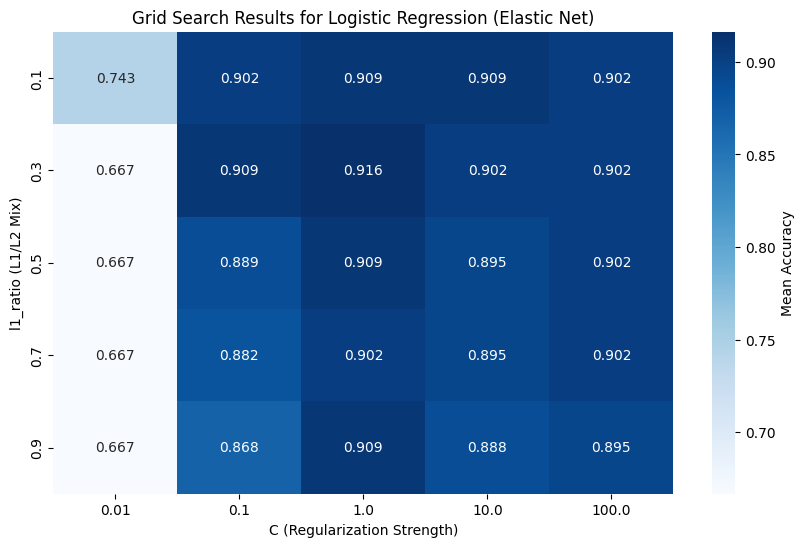

Best Parameters: {'C': 1, 'l1_ratio': 0.3}
Best Cross-Validation Score: 0.9163


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Step 1: Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # L1-L2 mix ratio
}

# Step 2: Initialize the Logistic Regression with Elastic Net
log_reg_elastic = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)

# Step 3: Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=log_reg_elastic, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 4: Fit the GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Step 5: Extract the cross-validation results
results = grid_search.cv_results_

# Step 6: Convert results to a DataFrame for easier plotting
import pandas as pd
cv_results_df = pd.DataFrame(results)

# Step 7: Create a pivot table to organize mean test scores by l1_ratio and C
pivot_table = cv_results_df.pivot(index='param_l1_ratio', columns='param_C', values='mean_test_score')

# Step 8: Plot the heatmap of the pivot table
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="Blues", cbar_kws={'label': 'Mean Accuracy'})
plt.title("Grid Search Results for Logistic Regression (Elastic Net)")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("l1_ratio (L1/L2 Mix)")
plt.show()

# Step 9: Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")


Final Test Accuracy: 0.9444
Final Confusion Matrix:
[[10  2]
 [ 0 24]]


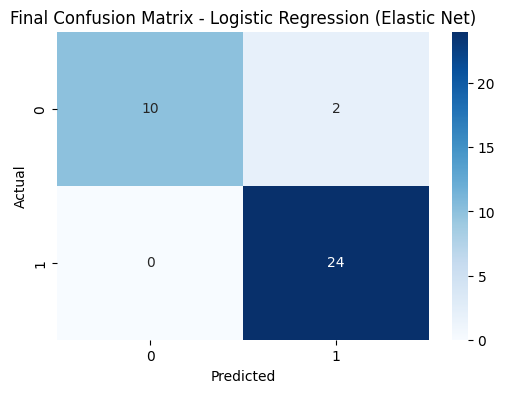

In [ ]:
# Train the final model using the best parameters
final_log_reg_elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.7, C=1, max_iter=10000)
final_log_reg_elastic.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_test_pred_final = final_log_reg_elastic.predict(X_test_scaled)

# Evaluate the final model on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred_final)
final_cm = confusion_matrix(y_test, y_test_pred_final)

print(f"Final Test Accuracy: {final_test_accuracy:.4f}")
print("Final Confusion Matrix:")
print(final_cm)

# Optionally plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(final_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Final Confusion Matrix - Logistic Regression (Elastic Net)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [57]:
final_log_reg_elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.7, C=1, max_iter=10000)
final_log_reg_elastic.fit(X_train_scaled, y_train)

scaled_coefficients = final_log_reg_elastic.coef_[0]
scaled_intercept = final_log_reg_elastic.intercept_[0]

unscaled_coefficients = scaled_coefficients / scaler.scale_
unscaled_intercept = scaled_intercept - np.sum((scaler.mean_ / scaler.scale_) * scaled_coefficients)

unscaled_coefficients_series = pd.Series(unscaled_coefficients, index=X.columns)
print("Unscaled Coefficients:", unscaled_coefficients_series)
print("Unscaled Intercept:", unscaled_intercept)

Unscaled Coefficients: Пол          0.000000
Возраст     -0.050985
О.ж.,%       0.040147
Висц.ж,%     0.376490
Мыш.м,%     -0.132765
Скелет,%     0.000000
Кости,кг     0.000000
Вода,%      -0.001737
СООВ,ккал    0.000000
ОГ,см       -0.068703
ОТ,см        0.023786
ОЖ,см        0.011485
ОБ,см        0.000000
ИМТ          0.203377
АЛТ          0.110681
АСТ          0.064737
ГГТП         0.082478
ЩФ           0.019884
ХСобщ.       0.335962
ЛПНП        -0.633658
ЛПВП         0.000000
Триглиц.     0.000000
Билир.о     -0.013027
Билир.пр     0.000000
Глюкоза      0.053802
Инсулин      0.000000
Ферритин    -0.003972
СРБ         -0.136714
О.белок     -0.081790
Моч.к-та     0.000000
dtype: float64
Unscaled Intercept: 0.9558742218995437


In [59]:
def predict_with_unscaled_data(row):
    y_pred = unscaled_intercept
    for feature, coef in zip(X.columns, unscaled_coefficients):
        y_pred += coef * row[feature]
    return y_pred

predictions = combined_df.apply(predict_with_unscaled_data, axis=1)

predicted_probabilities = 1 / (1 + np.exp(-predictions))

predicted_classes = (predicted_probabilities >= 0.5).astype(int)

results_df = pd.DataFrame({
    'raw_prediction': predictions,
    'predicted_probability': predicted_probabilities,
    'predicted_class': predicted_classes,
    'actual_class': combined_df['Group']  # Assuming 'Group' is the actual label column
})

print(results_df.head())

   raw_prediction  predicted_probability  predicted_class  actual_class
0        2.639228               0.933344                1             1
1        1.529693               0.821961                1             1
2        8.146239               0.999710                1             1
3        5.142092               0.994189                1             1
4       13.015088               0.999998                1             1


In [ ]:

cm = confusion_matrix(results_df['actual_class'], results_df['predicted_class'])
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(results_df['actual_class'], results_df['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(results_df['actual_class'], results_df['predicted_class'])
print("Classification Report:")
print(report)

## Web App

In [60]:
!pip install streamlit ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.3 MB/s eta 0:00:00


### Code - function

In [31]:
# Saving the improved Streamlit app code with gender-based logic for normal ranges and blue design
with open('health_prediction_app.py', 'w') as f:
    f.write("""
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt

# Define the unscaled coefficients and intercept
unscaled_coefficients = {
    'О.ж.,%': 0.011731,
    'Висц.ж,%': 0.256571,
    'Мыш.м,%': -0.118061,
    'ИМТ': 0.175329,
    'АЛТ': 0.109809,
    'АСТ': 0.060320,
    'ГГТП': 0.063493,
    'О.белок': -0.118442
}

unscaled_intercept = 1.01741283

# Function to predict probability and class based on input features
def predict_probability_and_class(features, threshold=0.5):
    y_pred = unscaled_intercept
    for feature, coef in unscaled_coefficients.items():
        y_pred += coef * features.get(feature, 0)
    probability = 1 / (1 + np.exp(-y_pred))
    predicted_class = "Болен" if probability >= threshold else "Здоров"
    return probability, predicted_class

# Streamlit App Interface
st.set_page_config(page_title="Прогноз НАЖБП", page_icon="💉", layout="wide")

# App Title and Description
st.title("💉 Прогноз НАЖБП")
st.write("Введите значения показателей для получения прогноза вероятности НАЖБП.")

# Gender selection
gender = st.radio("**Выберите пол:**", ("Мужской", "Женский"))

# Adjust normal ranges based on gender
if gender == "Мужской":
    normal_ranges = {
        'Ожирение, %': (10, 20),
        'Висцеральный жир, %': (5, 15),
        'Мышечная масса, %': (40, 50),
        'ИМТ': (18.5, 24.9),
        'АЛТ (ед/л)': (7, 56),
        'АСТ (ед/л)': (8, 48),
        'ГГТП (ед/л)': (9, 48),
        'Общий белок (г/л)': (6.0, 8.3)
    }
else:
    normal_ranges = {
        'Ожирение, %': (18, 28),
        'Висцеральный жир, %': (5, 15),
        'Мышечная масса, %': (30, 40),
        'ИМТ': (18.5, 24.9),
        'АЛТ (ед/л)': (7, 56),
        'АСТ (ед/л)': (8, 48),
        'ГГТП (ед/л)': (9, 48),
        'Общий белок (г/л)': (6.0, 8.3)
    }

# Layout for input and results
col1, col2 = st.columns(2)

with col1:
    st.header("**Введите показатели:**")
    О_ж = st.number_input("**Ожирение, %**", min_value=0.0, max_value=100.0, value=25.0)
    Висц_ж = st.number_input("**Висцеральный жир, %**", min_value=0.0, max_value=100.0, value=15.0)
    Мыш_м = st.number_input("**Мышечная масса, %**", min_value=0.0, max_value=100.0, value=45.0)
    ИМТ = st.number_input("**Индекс массы тела (ИМТ)**", min_value=0.0, max_value=100.0, value=24.0)
    АЛТ = st.number_input("**АЛТ (ед/л)**", min_value=0.0, max_value=200.0, value=30.0)
    АСТ = st.number_input("**АСТ (ед/л)**", min_value=0.0, max_value=200.0, value=20.0)
    ГГТП = st.number_input("**ГГТП (ед/л)**", min_value=0.0, max_value=200.0, value=55.0)
    О_белок = st.number_input("**Общий белок (г/л)**", min_value=0.0, max_value=20.0, value=6.0)

with col2:
    if st.button("Рассчитать Прогноз"):
        # Input features
        input_features = {
            'О.ж.,%': О_ж,
            'Висц.ж,%': Висц_ж,
            'Мыш.м,%': Мыш_м,
            'ИМТ': ИМТ,
            'АЛТ': АЛТ,
            'АСТ': АСТ,
            'ГГТП': ГГТП,
            'О.белок': О_белок
        }
        probability, predicted_class = predict_probability_and_class(input_features)

        # Display the results with visuals
        st.subheader("**Результаты Прогноза:**")
        st.write(f"**Вероятность:** {probability:.4f}")
        st.write(f"**Класс:** {predicted_class}")

        if predicted_class == "Болен":
            st.error("Модель предсказывает, что вы больны.")
        else:
            st.success("Модель предсказывает, что вы здоровы.")

        # Visual comparison of inputs vs normal ranges
        st.subheader("**Сравнение введенных значений с нормальными диапазонами**")
        fig, ax = plt.subplots(figsize=(8, 5))
        features = ['Ожирение, %', 'Висцеральный жир, %', 'Мышечная масса, %', 'ИМТ', 'АЛТ (ед/л)', 'АСТ (ед/л)', 'ГГТП (ед/л)', 'Общий белок (г/л)']
        user_values = [О_ж, Висц_ж, Мыш_м, ИМТ, АЛТ, АСТ, ГГТП, О_белок]
        normal_min = [normal_ranges[feat][0] for feat in features]
        normal_max = [normal_ranges[feat][1] for feat in features]

        # Ensure x and y are the same size by plotting for every feature
        # Plot normal ranges as horizontal lines
        for i, (min_val, max_val) in enumerate(zip(normal_min, normal_max)):
            ax.plot([min_val, max_val], [i, i], color='gray', lw=6, alpha=0.5, label='Нормальный диапазон' if i == 0 else "")

        # Plot user values as blue markers on top of the normal ranges
        ax.scatter(user_values, range(len(features)), color='blue', s=100, zorder=5, label='Ваши значения')

        # Design improvements
        ax.set_xlabel('Значения', fontsize=12, fontweight='bold')
        ax.set_title('Сравнение показателей с нормальными диапазонами', fontsize=14, fontweight='bold')

        # Customize ticks and labels
        ax.set_yticks(range(len(features)))
        ax.set_yticklabels(features, fontsize=11, fontweight='bold')
        ax.tick_params(axis='x', labelsize=10)
        ax.xaxis.label.set_size(12)

        # Remove right and top spines (axes)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Bold the axes
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)

        # Set grid for better readability
        ax.grid(True, axis='x', linestyle='--', alpha=0.6)

        # Add a legend with better positioning
        ax.legend(loc='lower right', fontsize=10)

        # Display the plot
        st.pyplot(fig)

# Footer
st.write("---")
st.write("Это приложение создано для помощи в прогнозе НАЖБП на основе различных показателей.")
st.write("Приложение использует биохимические маркеры, индекс массы тела, и другие параметры.")
st.write("Приложение НЕ создано для самостоятельной постановки диагноза.")
    """)

In [27]:
!pip install pyngrok

In [75]:
!ps -ef | grep streamlit

root       29712       1  0 10:38 ?        00:00:03 /usr/bin/python3 /usr/local/bin/streamlit run he
root       32809    1767  0 10:51 ?        00:00:00 /bin/bash -c ps -ef | grep streamlit
root       32811   32809  0 10:51 ?        00:00:00 grep streamlit


In [ ]:
#!killall -9 python3

In [28]:
!streamlit run health_prediction_app.py --server.port 8501 &>/dev/null&

In [29]:
from pyngrok import ngrok

ngrok.set_auth_token('2kBZ0My2aTS2A5YxsNl0Ak31Foz_6Cw12VVU49uDn7GSGZDdZ')

public_url = ngrok.connect(8501)
print(f"Public URL: {public_url}")

Public URL: NgrokTunnel: "https://6e2b-34-32-245-103.ngrok-free.app" -> "http://localhost:8501"


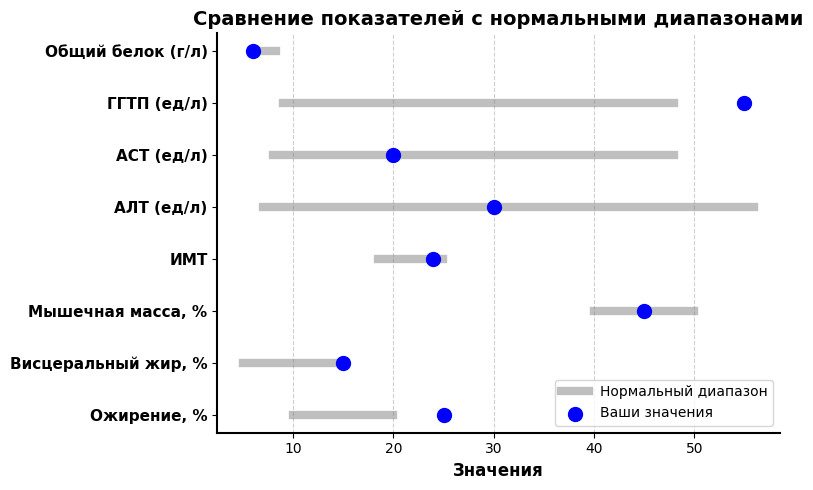

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate user input values
user_values = [25.0, 15.0, 45.0, 24.0, 30.0, 20.0, 55.0, 6.0]  # These are the values entered by the user

# Simulate gender and normal ranges
gender = "Мужской"  # Change to "Женский" to test female ranges

# Adjust normal ranges based on gender
if gender == "Мужской":
    normal_ranges = {
        'Ожирение, %': (10, 20),
        'Висцеральный жир, %': (5, 15),
        'Мышечная масса, %': (40, 50),
        'ИМТ': (18.5, 24.9),
        'АЛТ (ед/л)': (7, 56),
        'АСТ (ед/л)': (8, 48),
        'ГГТП (ед/л)': (9, 48),
        'Общий белок (г/л)': (6.0, 8.3)
    }
else:
    normal_ranges = {
        'Ожирение, %': (18, 28),
        'Висцеральный жир, %': (5, 15),
        'Мышечная масса, %': (30, 40),
        'ИМТ': (18.5, 24.9),
        'АЛТ (ед/л)': (7, 56),
        'АСТ (ед/л)': (8, 48),
        'ГГТП (ед/л)': (9, 48),
        'Общий белок (г/л)': (6.0, 8.3)
    }

# Plot comparison between user values and normal ranges
features = ['Ожирение, %', 'Висцеральный жир, %', 'Мышечная масса, %', 'ИМТ', 'АЛТ (ед/л)', 'АСТ (ед/л)', 'ГГТП (ед/л)', 'Общий белок (г/л)']
normal_min = [normal_ranges[feat][0] for feat in features]
normal_max = [normal_ranges[feat][1] for feat in features]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot normal ranges as horizontal lines (with error bars)
for i, (min_val, max_val) in enumerate(zip(normal_min, normal_max)):
    ax.plot([min_val, max_val], [i, i], color='gray', lw=6, alpha=0.5, label='Нормальный диапазон' if i == 0 else "")

# Plot user values as markers on top of the normal ranges
ax.scatter(user_values, range(len(features)), color='blue', s=100, zorder=5, label='Ваши значения')

# Design improvements
ax.set_xlabel('Значения', fontsize=12, fontweight='bold')
ax.set_title('Сравнение показателей с нормальными диапазонами', fontsize=14, fontweight='bold')

# Customize ticks and labels
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features, fontsize=11, fontweight='bold')
ax.tick_params(axis='x', labelsize=10)
ax.xaxis.label.set_size(12)

# Remove right and top spines (axes)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Bold the axes
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Set grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.6)

# Add a legend with better positioning
ax.legend(loc='lower right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

### Other - FLASK

In [ ]:
from pyngrok import ngrok

# Replace 'your_auth_token' with the token you copied from Ngrok's dashboard
ngrok.set_auth_token('2kBZ0My2aTS2A5YxsNl0Ak31Foz_6Cw12VVU49uDn7GSGZDdZ')

# Create a tunnel to the Flask app
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000\"")

 * ngrok tunnel "NgrokTunnel: "https://eb45-35-227-140-28.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000"


In [ ]:
from flask import Flask, render_template_string, request, jsonify
import numpy as np

# Initialize Flask app
app = Flask(__name__)

# Define the model parameters based on the given equation
intercept_adjusted = -5.8922
coefficients_adjusted = {
    'Пол': 1.3358,
    'АСТ': 0.1574,
    'ГГТП': 0.0936,
    'ЛПВП': -0.4675,
    'Триглиц.': 0.1024,
    'Билир.о': -0.0495,
    'СРБ': -0.0726
}

selected_features = list(coefficients_adjusted.keys())

# Define HTML template
html_template = '''
<!DOCTYPE html>
<html lang="ru">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Прогнозирование НАЖБП</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            color: #333;
            margin: 0;
            padding: 0;
        }
        .container {
            width: 80%;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            background: #fff;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
            border-radius: 8px;
        }
        h1 {
            text-align: center;
            color: #007BFF;
        }
        label {
            display: block;
            margin: 10px 0 5px;
        }
        input[type="text"] {
            width: calc(100% - 22px);
            padding: 10px;
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 4px;
        }
        input[type="submit"] {
            background-color: #007BFF;
            color: #fff;
            border: none;
            padding: 10px 20px;
            border-radius: 4px;
            cursor: pointer;
            font-size: 16px;
        }
        input[type="submit"]:hover {
            background-color: #0056b3;
        }
        #result {
            margin-top: 20px;
            padding: 15px;
            background: #e9ecef;
            border: 1px solid #ddd;
            border-radius: 4px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Прогнозирование НАЖБП - Анкета</h1>
        <form action="/predict" method="post">
            <label for="Пол">Пол (ж/м):</label>
            <select id="Пол" name="Пол" required>
                <option value="1">ж</option>
                <option value="0">м</option>
            </select><br>
            <label for="АСТ">Аспартатаминотрансфераза (АСТ):</label>
            <input type="text" id="АСТ" name="АСТ" required><br>
            <label for="ГГТП">Гамма-глутамилтрансфераза (ГГТП):</label>
            <input type="text" id="ГГТП" name="ГГТП" required><br>
            <label for="ЛПВП">Липопротеины высокой плотности (ЛПВП):</label>
            <input type="text" id="ЛПВП" name="ЛПВП" required><br>
            <label for="Триглиц.">Триглицериды (Триглиц.):</label>
            <input type="text" id="Триглиц." name="Триглиц." required><br>
            <label for="Билир.о">Билирубин общий (Билир.о):</label>
            <input type="text" id="Билир.о" name="Билир.о" required><br>
            <label for="СРБ">С-реактивный белок (СРБ):</label>
            <input type="text" id="СРБ" name="СРБ" required><br>
            <input type="submit" value="Отправить">
        </form>
        <div id="result"></div>
    </div>
    <script>
        const form = document.querySelector('form');
        form.addEventListener('submit', async (e) => {
            e.preventDefault();
            const formData = new FormData(form);
            const response = await fetch('/predict', {
                method: 'POST',
                body: formData
            });
            const result = await response.json();
            const resultDiv = document.getElementById('result');
            if (result.error) {
                resultDiv.innerHTML = `<p>Error: ${result.error}</p>`;
            } else {
                resultDiv.innerHTML = `<p>Прогноз: ${result.prediction}</p><p>Вероятность: ${result.probability.toFixed(4)}</p>`;
            }
        });
    </script>
</body>
</html>
'''

@app.route('/')
def home():
    return render_template_string(html_template, features=selected_features)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Retrieve form data
        data = [float(request.form[feature]) for feature in selected_features]

        # Convert gender to numeric value
        gender = float(request.form['Пол'])

        # Calculate prediction using logistic regression equation
        prediction = intercept_adjusted
        for feature, coef in coefficients_adjusted.items():
            if feature == 'Пол':
                prediction += coef * gender
            else:
                prediction += coef * data[selected_features.index(feature)]

        # Apply sigmoid function
        p_value = 1 / (1 + np.exp(-prediction))

        # Convert prediction to readable format
        result = 'Положительно' if p_value > 0.5 else 'Отрицательно'

        return jsonify({'Прогноз': result, 'Вероятность': p_value})

    except Exception as e:
        return jsonify({'error': str(e)})

# Create a tunnel to the Flask app
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000\"")

if __name__ == '__main__':
    app.run()

 * ngrok tunnel "NgrokTunnel: "https://e716-35-227-140-28.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [04/Aug/2024 11:15:28] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [04/Aug/2024 11:15:28] "GET /favicon.ico HTTP/1.1" 404 -


#### Offline App

In [ ]:
import tkinter as tk
from tkinter import messagebox
import numpy as np

# Define the model parameters based on the given equation
intercept_adjusted = -5.8922
coefficients_adjusted = {
    'Пол': 1.3358,
    'АСТ': 0.1574,
    'ГГТП': 0.0936,
    'ЛПВП': -0.4675,
    'Триглиц.': 0.1024,
    'Билир.о': -0.0495,
    'СРБ': -0.0726
}

# Define the prediction function
def calculate_nlfd_prediction(gender, ast, ggtp, lpvp, trigl, bilirr, crb):
    prediction = intercept_adjusted
    prediction += coefficients_adjusted['Пол'] * gender
    prediction += coefficients_adjusted['АСТ'] * ast
    prediction += coefficients_adjusted['ГГТП'] * ggtp
    prediction += coefficients_adjusted['ЛПВП'] * lpvp
    prediction += coefficients_adjusted['Триглиц.'] * trigl
    prediction += coefficients_adjusted['Билир.о'] * bilirr
    prediction += coefficients_adjusted['СРБ'] * crb

    # Apply sigmoid function
    p_value = 1 / (1 + np.exp(-prediction))
    return p_value

def on_submit():
    try:
        gender = int(gender_var.get())
        ast = float(ast_var.get())
        ggtp = float(ggtp_var.get())
        lpvp = float(lpvp_var.get())
        trigl = float(trigl_var.get())
        bilirr = float(bilirr_var.get())
        crb = float(crb_var.get())

        p_value = calculate_nlfd_prediction(gender, ast, ggtp, lpvp, trigl, bilirr, crb)
        result = 'Положительно' if p_value > 0.5 else 'Отрицательно'

        messagebox.showinfo("Результат", f"Прогноз: {result}\nВероятность: {p_value:.4f}")
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите правильные значения.")

# Create the main window
root = tk.Tk()
root.title("Прогнозирование НАЖБП")

# Create and place labels and entries
tk.Label(root, text="Пол (ж/м):").grid(row=0, column=0, padx=10, pady=5, sticky="e")
gender_var = tk.StringVar(value="1")
tk.Radiobutton(root, text="ж", variable=gender_var, value="1").grid(row=0, column=1, padx=10, pady=5)
tk.Radiobutton(root, text="м", variable=gender_var, value="0").grid(row=0, column=2, padx=10, pady=5)

tk.Label(root, text="Аспартатаминотрансфераза (АСТ):").grid(row=1, column=0, padx=10, pady=5, sticky="e")
ast_var = tk.StringVar()
tk.Entry(root, textvariable=ast_var).grid(row=1, column=1, columnspan=2, padx=10, pady=5)

tk.Label(root, text="Гамма-глутамилтрансфераза (ГГТП):").grid(row=2, column=0, padx=10, pady=5, sticky="e")
ggtp_var = tk.StringVar()
tk.Entry(root, textvariable=ggtp_var).grid(row=2, column=1, columnspan=2, padx=10, pady=5)

tk.Label(root, text="Липопротеины высокой плотности (ЛПВП):").grid(row=3, column=0, padx=10, pady=5, sticky="e")
lpvp_var = tk.StringVar()
tk.Entry(root, textvariable=lpvp_var).grid(row=3, column=1, columnspan=2, padx=10, pady=5)

tk.Label(root, text="Триглицериды (Триглиц.):").grid(row=4, column=0, padx=10, pady=5, sticky="e")
trigl_var = tk.StringVar()
tk.Entry(root, textvariable=trigl_var).grid(row=4, column=1, columnspan=2, padx=10, pady=5)

tk.Label(root, text="Билирубин общий (Билир.о):").grid(row=5, column=0, padx=10, pady=5, sticky="e")
bilirr_var = tk.StringVar()
tk.Entry(root, textvariable=bilirr_var).grid(row=5, column=1, columnspan=2, padx=10, pady=5)

tk.Label(root, text="С-реактивный белок (СРБ):").grid(row=6, column=0, padx=10, pady=5, sticky="e")
crb_var = tk.StringVar()
tk.Entry(root, textvariable=crb_var).grid(row=6, column=1, columnspan=2, padx=10, pady=5)

tk.Button(root, text="Отправить", command=on_submit).grid(row=7, column=0, columnspan=3, padx=10, pady=20)

# Start the Tkinter event loop
root.mainloop()

In [ ]:
def calculate_nlfd_prediction(gender, ast, ggtp, lpvp, trigl, insulin, ferrit, crb):
    intercept = intercept_adjusted

    coefficients = {
        'Пол': coefficients_adjusted[0],
        'АСТ': coefficients_adjusted[1],
        'ГГТП': coefficients_adjusted[2],
        'ЛПВП': coefficients_adjusted[3],
        'Триглиц.': coefficients_adjusted[4],
        'Инсулин': coefficients_adjusted[5],
        'Ферритин': coefficients_adjusted[6],
        'СРБ': coefficients_adjusted[7],
    }

    # Вычислите предсказание на основе введенных значений
    prediction = intercept
    prediction += coefficients['Пол'] * gender
    prediction += coefficients['АСТ'] * ast
    prediction += coefficients['ГГТП'] * ggtp
    prediction += coefficients['ЛПВП'] * lpvp
    prediction += coefficients['Триглиц.'] * trigl
    prediction += coefficients['Инсулин'] * insulin
    prediction += coefficients['Ферритин'] * ferrit
    prediction += coefficients['СРБ'] * crb

    # Примените функцию сигмоида для преобразования результата в вероятность от 0 до 1
    p_value = expit(prediction)

    return p_value

df = dataframes[0]  # Предположим, что это ваш DataFrame

# Выберите нужные столбцы
selected_columns = ['Пол', 'АСТ', 'ГГТП', 'ЛПВП', 'Триглиц.', 'Инсулин', 'Ферритин', 'СРБ']

if 'Пол' in selected_columns:
    df['Пол'] = df['Пол'].replace({'жен': 1, 'муж': 0})

# Проверьте, есть ли все нужные столбцы в DataFrame
for col in selected_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing from the DataFrame")

# df['NLFD_Prediction'] = df.apply(lambda row: calculate_nlfd_prediction(
#     row['Пол'],
#     row['АСТ'],
#     row['ГГТП'],
#     row['ЛПВП'],
#     row['Триглиц.'],
#     row['Инсулин'],
#     row['Ферритин'],
#     row['СРБ'],
# ), axis=1)

# print(df[['ФИО', 'NLFD_Prediction']])

                                ФИО  NLFD_Prediction
0      Чаликова Виктория Валерьевна         0.900859
1   Сидорова Екатерина Владимировна         0.891948
2        Кузнецова Ольга Николаевна         0.982425
3            Попов Андрей Андреевич         0.683255
4         Андронова Марина Карловна         0.999373
5     Зайцева Светлана Вячеславовна         0.994550
6     Зайцев Александр Вячеславович         0.928429
7      Сальников Андрей Анатольевич         0.978608
8         Козлова Оксана Георгиевна         0.973847
9        Белякова Татьяна Борисовна         0.938817
10          Савва Дмитрий Андреевич         0.998904
11      Туфанов Дмитрий Анатольевич         0.999781
12        Виноградова Ольга Юрьевна         0.784872
13     Виноградов Сергей Николаевич         0.973790
14         Симакин Амаль Викторович         0.842247
15       Булавина Влада Андрияновна         0.426616
16         Посух Василий Васильевич         0.991911
17      Мещерякова Людмила Ивановна         0.